<a href="https://colab.research.google.com/github/slowings/Phase_4_Final_Project/blob/main/Phase_4_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Overview
### Our Client
Our client, a national non-profit healthcare provider called WeCare, is working on developing a virtual doctor, or vMD. With a growing number of local hospitals and medical offices closing in rural areas, WeCare is seeking to to open a series of clinics to service these under-resourced zones. In order to do so, they plan on taking advantage of the benefits of telehealth to connect patients and doctors while maintaining a on-site staff of technicians and Nurse Practitioners, who will be able to test, diagnose and perscribe with the additional assistance of vMD. Our small part of this monumental task is building a deep neural network that detects pediatric pnuemonia with a significant degree of precision and recall.

### The Problem With Pneumonia
Over the last 20 years, pneumonia (a disease that causes inflammation of either one or both lungs) has been a leading cause of death for children under 5 worldwide, and it is the 6th most common cause of childhood death in the US. In 2019 alone, pneumonia caused the death of 1.9 million children worldwide- approximately 2000 children a day die of pneumonia. In the U.S., children younger than 5 years of age accounted for 70 percent of pneumonia hospitalizations, at an economic cost of about 1 billion dollars. Developing models to quickly and accurately diagnose pneumonia from xrays is one meaningful step towards lessening the toll of this disease, both human and economic, as treatment is often highly effective once pneumonia has been identified.

### Our Data
To train our model we'll be using a publically available database, "Chest X-Ray Images (pnuemonia)" from Kaggle, which consists of 5,863 entries, or xrays, split into 3 sections: train (entries), test (entries), and val (entries). These xrays were taken of anonyomous pediatric patients, aged one to five years old, from Guangzhou Women and Children’s Medical Center, Guangzhou, China. These images have been rigorously screened for quality control, with unreadable and low quality scans discarded, and the remaining train and test set scans graded by two pysicians, and reviewed by third.

Our images come in a variety of sizes and colors. While altering the color input (for instance, by changing all the images to greyscale) would likely improve our models runtime, the variety of input from using both black and white and color images will mean that our model is better trained to detect pneumonia in both, a more desirable attribute for scaling up to national model, where there will be a variety of color or black and white images. We will try both, using a mix of images for our vanilla classifier, and converting images to greyscale for use with our CNN

### Our Model
In our model, we'll be looking to maximize our identification of true positives (precision) and minimize false negatives (recall); In other words to be sure we are correctly identifying as many actual cases of pnuemonia, and missing as few instances of illness as possible. In order to do so, we'll employ an iterative approach to designing a deeply connected neural network that is progressively tuned from a vanilla classifier with few hidden layers towards our goal, a Convolutional Nueral Network, or CNN to train and test our data. CNN's are uniquely suited to image classification for a number of reasons, the most important being that they quickly learn to recognize patterns and extract features from images, while also being able to process large amounts of data and produce accurate predictions. The underlying archetecture of a CNN takes an image and maps it's most important features (while dropping irrelevant information) to increasingly smaller tensors, effectively concentrating identifyers while reducing processing needs.

Our training set contains 3875 of the xrays of patients that have been identified as having pnuemonia and 1341 who do not have pnuemonia, a class imbalance we'll deal with through undersampling in order to minimize the longer runtimes associated with oversampling visual data to accomodate disproportionate representation. As we build our model, we'll pay special attention to the bias/variance trade-off (under and over fitting), as well as establishing proper parameter initialization in order to optimize our model's performance. Additionally, we'll normalize inputs to speed things up, and help mitigate the issue of vanishing or exploding gradients.

Let's begin by importing the neccessary libraries to load, visualize, and preprocess our data.

In [1]:
import os, shutil
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive


## Data Visualization and Preprocessing
In this section we'll take a preliminary look at our data to get a feel for what we're working with.  We'll examine the numbers of normal and infected patients in the train, test and val sets to check for class imbalances, plot a random sample of xrays from our train set,  and determine our course of action for preprocessing.  This will likely involve resizing our data, binary encoding our target variable, and augmenting our data.

Let's begin by taking a look at the contents of our data directory

In [2]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'sample_data']


In [3]:
# Set path to xrays
drive_path = '/gdrive/MyDrive/Data/archive.zip'


In [4]:
# Navigate to xrays
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'archive.zip', 'sample_data']


In [5]:
# Unzip images
!unzip -q 'archive.zip'

### Check distribution
Now that we've confirmed the file path and unzipped our data, let's take a moment to create our paths to our data, and then investigate the distribution of 'normal' vs. 'pneumonia' xrays in the train, test, and val directories.

In [6]:
# Define paths to train, test and val sets
train_folder = '/content/chest_xray/train'
train_pneu = '/content/chest_xray/train/PNEUMONIA'
train_norm = '/content/chest_xray/train/NORMAL'

test_folder = '/content/chest_xray/test'
test_pneu = '/content/chest_xray/test/PNEUMONIA'
test_norm = '/content/chest_xray/test/NORMAL'

val_folder = '/content/chest_xray/val'
val_pneu = '/content/chest_xray/val/PNEUMONIA'
val_norm = '/content/chest_xray/val/NORMAL'

# Print distribution
print('Train PNEUMONIA= ', len(os.listdir(train_pneu)))
print('Train NORMAL= ', len(os.listdir(train_norm)))

print('Test PNEUMONIA= ', len(os.listdir(test_pneu)))
print('Test NORMAL= ', len(os.listdir(test_norm)))

print('Val PNEUMONIA= ', len(os.listdir(val_pneu)))
print('Val NORMAL= ', len(os.listdir(val_norm)))


Train PNEUMONIA=  3875
Train NORMAL=  1341
Test PNEUMONIA=  390
Test NORMAL=  234
Val PNEUMONIA=  8
Val NORMAL=  8


We can see there's a significant class imbalance in the "train" set, while the test set is closer to a balanced distribution, and that our val set is perfectly balanced, but also very small.  We'll need to account for the class imbalance in our train data by undersampling the majority data (Pneumonia) to minimize our GPU usage and run times.

### Inspect Images

We'll plot a random sample of our train xrays to visually inspect them next, looking first at normal and then the pneumonia cases

In [ ]:
# Get a list of all images and filenames in the "Normal" directory
normal = os.listdir('/content/chest_xray/train/NORMAL')
normal_dir = '/content/chest_xray/train/NORMAL'

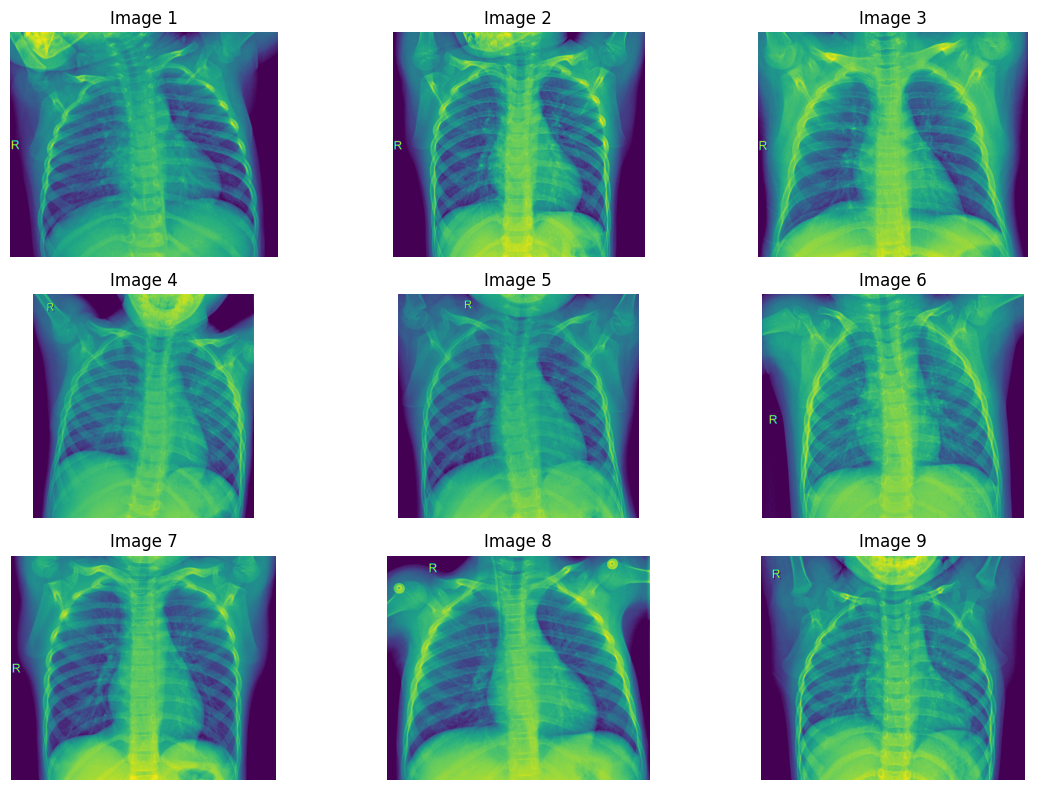

In [ ]:
# Set np random seed for replicable results
np.random.seed(18)

# Choose 9 random indices from the list of image filenames
num_images_to_display = 9
random_indices = np.random.choice(len(normal), num_images_to_display, replace=False)

# Plot the 9 random images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices, 1):
    img_path = os.path.join(normal_dir, normal[idx])
    image = plt.imread(img_path)

    plt.subplot(3, 3, i)
    plt.imshow(image)
    plt.title(f"Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Plotting our images revealed an pressing problem, our normal samples are of visably different sizes. Without a fixed input shape, we cannot define the architecture of our model.  We will need to resolve this by resizing the samples to standardize the image shape before creating our model.

Now let's look at a sample of xrays for 'pnuemonia'.  When interpreting an X-ray, a radiologist looks for white spots in the lungs, called infiltrates, that identify an infection.  These are quite difficult for an untrained eye to spot, hence the need for this model.  We'll display these to verify that the xrays are readable, and are roughly the same format as our pneumonia train data.

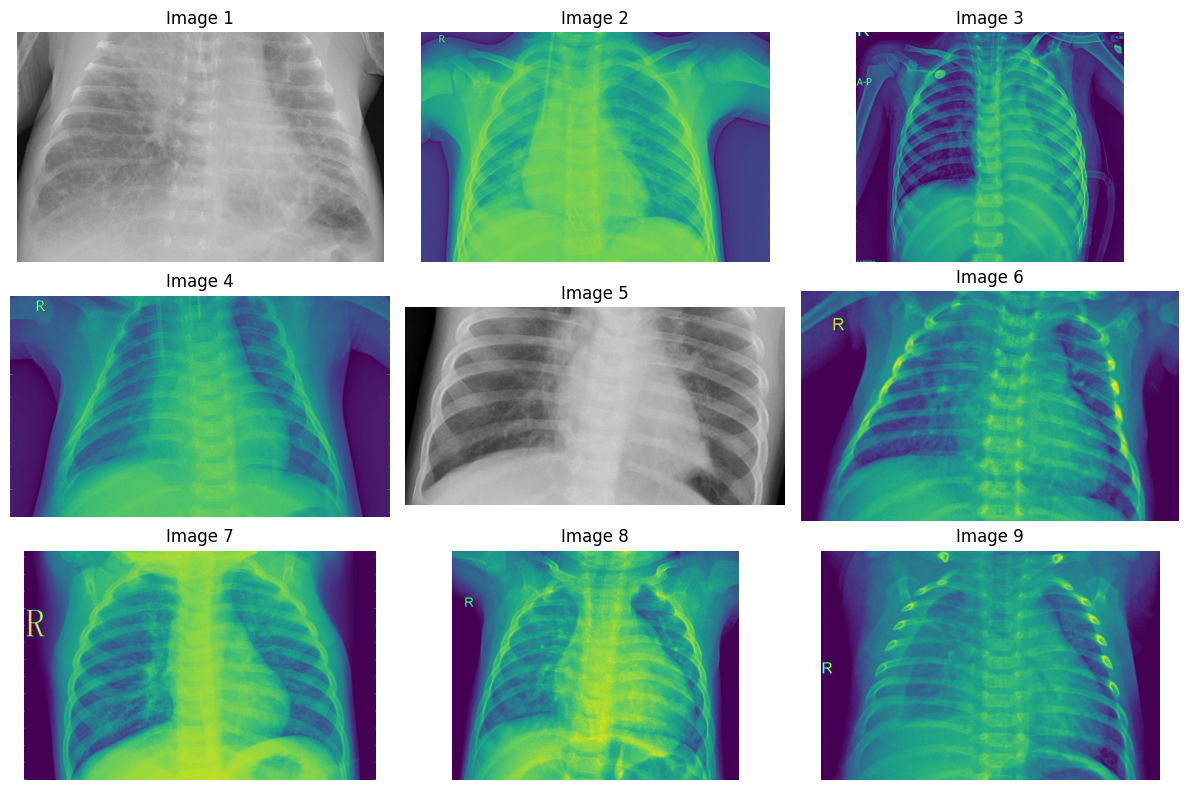

In [ ]:
#Define np random seed for replicable results
np.random.seed(18)

# Define the path to the dataset
pneumonia = os.listdir('/content/chest_xray/train/PNEUMONIA')
pneumonia_dir = '/content/chest_xray/train/PNEUMONIA'

# Choose 9 random indices from the list of image filenames
num_images_to_display = 9
random_indices = np.random.choice(len(pneumonia), num_images_to_display, replace=False)

# Plot the 9 random images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices, 1):
    img_path = os.path.join(pneumonia_dir, pneumonia[idx])
    image = plt.imread(img_path)

    plt.subplot(3, 3, i)
    plt.imshow(image)
    plt.title(f"Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


It's quite difficult for my untrained eye to see a significant difference between the normal and pneumonia samples.  However, it is clear that our train pneumonia set will also need to be resized as the first preprocessing step.  We'll assume that our test and val sets also contain data of varying shapes, and so we'll need to make sure to standardize the size of the inputs.  Below, we'll examine two files at random to more closely look at their shapes and outputs to determine if we should shrink or pad them.  Ideally we'd want our images to be as large as possible, the better to train our model with.  But, as mentioned, we'd like to keep our model run times to a minumum, and therefore we'll shrink them to a standard size if the shape height or width exceeds 500.

In [ ]:
# Confirm varied image size by taking samples and printing shape
image_path = '/content/chest_xray/train/PNEUMONIA'

# Get the list of images in the dataset
image_files = os.listdir(image_path)

# Get the first image file
first_image_file = image_files[0]

# Load the image using OpenCV
image = cv2.imread(os.path.join(image_path, first_image_file))

# Get the dimensions of the image
height, width, channels = image.shape

print("Image Width:", width)
print("Image Height:", height)
print("Number of Channels:", channels)

Image Width: 668
Image Height: 375
Number of Channels: 3


In [ ]:
# Get a different image file
second_image_file = image_files[23]

# Load the image using OpenCV
image = cv2.imread(os.path.join(image_path, second_image_file))

# Get the dimensions of the image
height, width, channels = image.shape

print("Image Width:", width)
print("Image Height:", height)
print("Number of Channels:", channels)

Image Width: 1256
Image Height: 840
Number of Channels: 3


Our images are quite large, and while they'll be distorted by resizing to a smaller standard shape, it will aid our models speed, and enable the use of pooling layers in our CNN architecture. Therefore, for preprocessing we'll reduce the shape to 224 X 224- not cropping but shrinking without consideration to the aspect ratio of the image. We'll also use the rescale argument to transform our pixel values to a float value between 0 and 1, which is then multiplied by the pixel values of the image in order to normalize the pixel values within a specific range. This is to reduce (again) the computational power needed to run our model- larger numbers mean more complex/lengthy calculations. We'll begin by importing the neccessary libraries for preprocessing our data and building our model

### Preprocessing

In [8]:
# Import Statements

import time
import scipy
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

### Generate Tensors
Below we'll create our dataframes of our rescaled and resized images, begining with defining the architecture of our ImageGenerators, whice will read in our data in batches, normalizing pixel output, scaling images, and set to the binary class mode for our target variable, y.

In [9]:
# get all the data in the "train" directory (5216 images), rescale and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder,
        target_size=(224, 224), batch_size=5216,
        class_mode='binary',
        shuffle=False,
        seed=18)

# get all the data in the "test" directory (624 images), rescale and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder,
        target_size=(224, 224), batch_size = 624,
        class_mode='binary',
        shuffle=False,
        seed=18)

# get all the data in the "split/validation" directory (16 images), rescale and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder,
        target_size=(224, 224), batch_size = 16,
        class_mode='binary',
        shuffle=False,
        seed=18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
# Batch feed and join images/labels to create data sets
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [ ]:
# Explore dataset again to ensure all files are there and in desired shape
print ("Train_images shape: " + str(X_train.shape))
print ("Train_labels shape: " + str(y_train.shape))
print ("Test_images shape: " + str(X_test.shape))
print ("Test_labels shape: " + str(y_test.shape))
print ("Val_images shape: " + str(X_val.shape))
print ("Val_labels shape: " + str(y_val.shape))

Train_images shape: (5216, 224, 224, 3)
Train_labels shape: (5216,)
Test_images shape: (624, 224, 224, 3)
Test_labels shape: (624,)
Val_images shape: (16, 224, 224, 3)
Val_labels shape: (16,)


### Flattening
Before we build our model we'll need to flatten each image from a 2D grid of pixel values into a 1D array of pixel values. We'll store this as a seperate variable, so that we can continue to use our train, test, and val sets for our CNN

In [10]:
# Flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

print(X_train_flat.shape)
print(X_test_flat.shape)
print(X_val_flat.shape)

(5216, 150528)
(624, 150528)
(16, 150528)


In [ ]:
# Inspect labels to verify proper shape and label
print(y_train[:10])
print(y_train.shape)
train_generator.class_indices

[1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
(5216,)


{'NORMAL': 0, 'PNEUMONIA': 1}

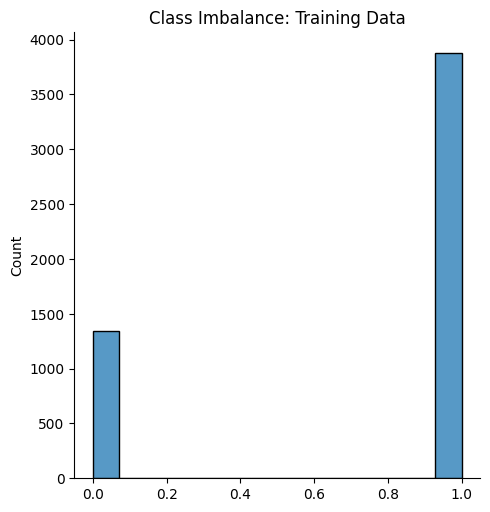

In [ ]:
# Lets quickly visualize our labels
sns.displot(y_train)
plt.title('Class Imbalance: Training Data')
plt.show()

## Vanilla Classifier: 1st Model
For our first model we'll begin with the most vanilla of classifiers, a one layer deep fully connected model. We'll be using a relu activation because our problem is binary, and sigmoid final layer for the same reason. After experimenting with optimizers, we wound up using Adam, as it performed slightly better than RMSprop.

In [12]:
# Define architecture of vanilla classifier with 1 hidden layer
model = models.Sequential()
model.add(layers.Dense(7, activation='relu', input_shape=(150528, )))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
# Compile model
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Fit model
history = model.fit(X_train_flat,
                    y_train,
                    epochs=10,
                    batch_size=20,
                    validation_data=(X_val_flat, y_val))

Epoch 1/10
261/261 [==============================] - 8s 8ms/step - loss: 0.6777 - acc: 0.7414 - val_loss: 0.6996 - val_acc: 0.5000
Epoch 2/10
261/261 [==============================] - 2s 7ms/step - loss: 0.6274 - acc: 0.7429 - val_loss: 0.7152 - val_acc: 0.5000
Epoch 3/10
261/261 [==============================] - 2s 7ms/step - loss: 0.6025 - acc: 0.7429 - val_loss: 0.7347 - val_acc: 0.5000
Epoch 4/10
261/261 [==============================] - 2s 7ms/step - loss: 0.5877 - acc: 0.7429 - val_loss: 0.7544 - val_acc: 0.5000
Epoch 5/10
261/261 [==============================] - 2s 7ms/step - loss: 0.5792 - acc: 0.7429 - val_loss: 0.7724 - val_acc: 0.5000
Epoch 6/10
261/261 [==============================] - 2s 7ms/step - loss: 0.5745 - acc: 0.7429 - val_loss: 0.7880 - val_acc: 0.5000
Epoch 7/10
261/261 [==============================] - 2s 7ms/step - loss: 0.5721 - acc: 0.7429 - val_loss: 0.8004 - val_acc: 0.5000
Epoch 8/10
261/261 [==============================] - 2s 7ms/step - loss: 0.

In [ ]:
# Get names of loss functions and metrics
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [14]:
def visualize_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """

  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['accuracy', 'val_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  y_hat_test = results.model.predict(X_test_flat)
  thresh = 0.5
  y_pred = (y_hat_test > thresh).astype(int)
  y_true = y_test.astype(int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predictions')
  plt.ylabel('Actual')
  plt.title('Test Confusion Matrix')
  plt.show()


# Check final metrics
  train_loss, train_acc= model.evaluate(X_train_flat, y_train)
  test_loss, test_acc= model.evaluate(X_test_flat, y_test)

  print('------------------------------')


  print(f'Train Loss: {train_loss}')
  print(f'Train Acc: {train_acc}')

  print('------------------------------')

  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')

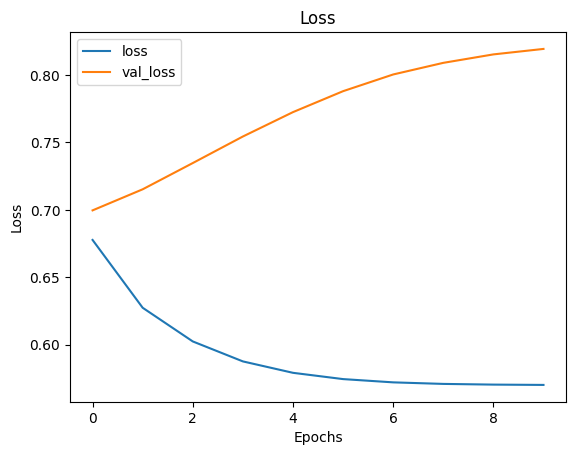

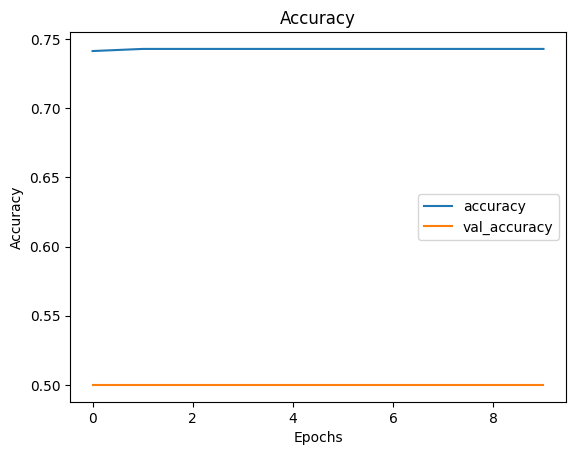

20/20 [==============================] - 0s 7ms/step


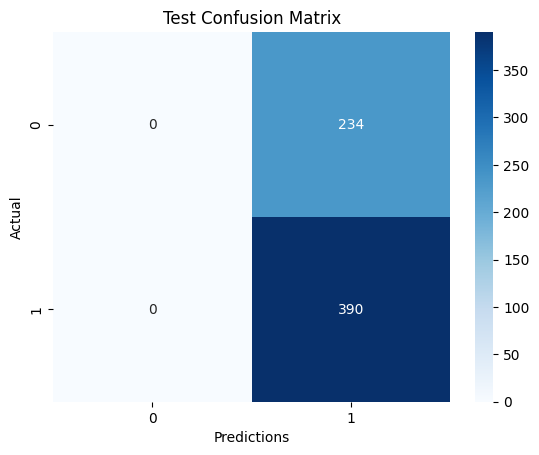

20/20 [==============================] - 0s 8ms/step - loss: 0.6911 - acc: 0.6250
------------------------------
Train Loss: 0.5701157450675964
Train Acc: 0.7429064512252808
------------------------------
Test Loss: 0.691064178943634
Test Acc: 0.625


In [15]:
visualize_results(history)

### Metrics
What AWFUL performance. Our train score of 74% accuracy is pretty bad, and our test was only 62%, barely better than randomly guessing.  Remeber that were looking to maximize identification of true positives (precision) and minimize false negatives (recall).  Our model is completely incapable of identifying pneumonia cases, with no true negatives.  We can also see our training and val accuracy are pretty flat, and that our test loss actually rises- since our validation scores are currently higher than our training scores. We'll try one more iteration of this classifier with one additional layer to attempt to improve our performance, and then turn to using a CNN, which will is better suited to image classification tasks.  One other thing we can do is check our threshold, to see if there's a better cutoff other than our standard .5.  We'll do that below, and then update our function as needed.

## Classifier With Additional Layers: 2nd Model

In this next iteration of our classifier we'll make three changes:  
1. We'll add one more hidden layer
2. We'll increase the number of dense layers to 20.
3. We'll increase the number of epochs to 20

In [16]:
# Define architecture of vanilla classifier with 2 hidden layers
model_2 = models.Sequential()
model_2.add(layers.Dense(20, activation='relu', input_shape=(150528, )))
model_2.add(layers.Dense(7, activation='relu'))
model_2.add(layers.Dense(5, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [17]:
# Compile model
model_2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Fit model
history_2 = model_2.fit(X_train_flat,
                    y_train,
                    epochs=20,
                    batch_size=20,
                    validation_data=(X_val_flat, y_val))

Epoch 1/20
261/261 [==============================] - 4s 8ms/step - loss: 0.6870 - acc: 0.7766 - val_loss: 0.7274 - val_acc: 0.6875
Epoch 2/20
261/261 [==============================] - 2s 8ms/step - loss: 0.3053 - acc: 0.8957 - val_loss: 0.5644 - val_acc: 0.7500
Epoch 3/20
261/261 [==============================] - 2s 7ms/step - loss: 0.2560 - acc: 0.9247 - val_loss: 0.6200 - val_acc: 0.7500
Epoch 4/20
261/261 [==============================] - 2s 7ms/step - loss: 0.2161 - acc: 0.9448 - val_loss: 0.3567 - val_acc: 0.9375
Epoch 5/20
261/261 [==============================] - 2s 7ms/step - loss: 0.1951 - acc: 0.9469 - val_loss: 0.3382 - val_acc: 1.0000
Epoch 6/20
261/261 [==============================] - 2s 8ms/step - loss: 0.1964 - acc: 0.9457 - val_loss: 0.4446 - val_acc: 0.8125
Epoch 7/20
261/261 [==============================] - 2s 7ms/step - loss: 0.2175 - acc: 0.9277 - val_loss: 0.4355 - val_acc: 0.8125
Epoch 8/20
261/261 [==============================] - 2s 8ms/step - loss: 0.

### Metrics


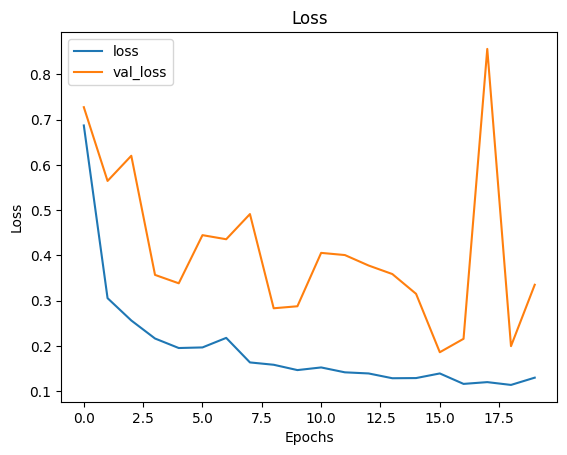

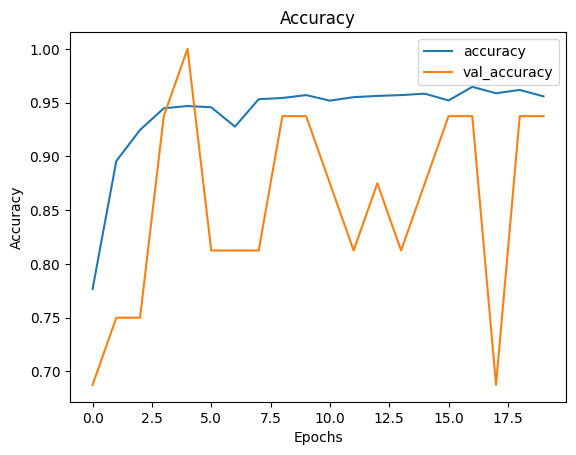

20/20 [==============================] - 0s 7ms/step


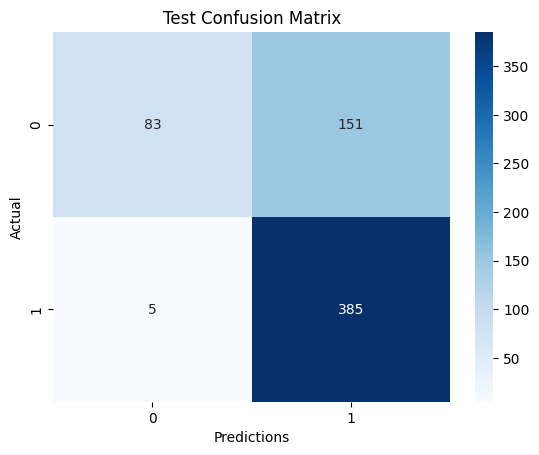

20/20 [==============================] - 0s 8ms/step - loss: 0.6911 - acc: 0.6250
------------------------------
Train Loss: 0.5701157450675964
Train Acc: 0.7429064512252808
------------------------------
Test Loss: 0.691064178943634
Test Acc: 0.625


In [18]:
visualize_results(history_2)

From the wild fluctuations in the loss thats so noticable in our plots we can see that we'll benefit from adding an early cutoff.  Additionally, our model continues to do poorly at identifying  pneumonia as evidenced by our confusion matrix, although at least we see a slight improvement.  In our next model we'll switch over to a CNN, with hopes of improving our false positive rate,  and then go on to use Keras CallBacks earlystop to keep our model from over fitting on our train data.

## Baseline CNN: 3rd model
Convolutional Neural networks, or CNN's were inspired by the workings of the visual cortex in human and animal brains, in which images are processed by simple cells which sample small areas of the visual field and register linear elements, and complex cells, with larger receptive feilds that take in position of those edges relative to the edges of the feild. Similarly, a CNN identifies linear elements in images through convolution (mapping the highest values of a pixel in a given sector of our image) and pooling (shrinking an image to reduce its pixel density). Because of this, they perform exceptionally well with image classification, and are an excellent tool for medical analysis.

In the next section we'll start by building a vanilla CNN to classify our xrays, and add features in successive iterations to fine tune our model to optomize performance.  We'll start with our epochs adjusted down to 12, to see if that helps our overfitting problem.


In [19]:
model_3 = models.Sequential()
model_3.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])



In [ ]:
# inspect the shape of our model before fitting/training it and see how many training parameters we have
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 64)       

In [20]:
history_3 = model_3.fit(X_train,
                       y_train,
                       epochs=12,
                       batch_size=20,
                       validation_data=(X_val, y_val))

Epoch 1/12
261/261 [==============================] - 10s 13ms/step - loss: 0.4691 - acc: 0.7882 - val_loss: 1.2182 - val_acc: 0.6250
Epoch 2/12
261/261 [==============================] - 3s 12ms/step - loss: 0.2367 - acc: 0.9062 - val_loss: 1.0143 - val_acc: 0.5625
Epoch 3/12
261/261 [==============================] - 3s 12ms/step - loss: 0.1613 - acc: 0.9387 - val_loss: 0.4361 - val_acc: 0.7500
Epoch 4/12
261/261 [==============================] - 3s 11ms/step - loss: 0.1412 - acc: 0.9459 - val_loss: 0.5807 - val_acc: 0.6875
Epoch 5/12
261/261 [==============================] - 3s 11ms/step - loss: 0.1195 - acc: 0.9559 - val_loss: 0.3890 - val_acc: 0.8125
Epoch 6/12
261/261 [==============================] - 3s 11ms/step - loss: 0.1122 - acc: 0.9584 - val_loss: 0.4251 - val_acc: 0.7500
Epoch 7/12
261/261 [==============================] - 3s 11ms/step - loss: 0.1077 - acc: 0.9599 - val_loss: 0.3615 - val_acc: 0.8750
Epoch 8/12
261/261 [==============================] - 3s 12ms/step -

### Metrics

In [ ]:
history_dict_3 = history_3.history
history_dict_3.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [16]:
def visualize_CNN_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """

  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['accuracy', 'val_acc'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  y_hat_test = results.model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test > thresh).astype(int)
  y_true = y_test.astype(int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predictions')
  plt.ylabel('Actuals')
  plt.title('Test Confusion Matrix')
  plt.show()

  # Check final metrics
  train_loss, train_acc= results.model.evaluate(X_train, y_train)
  test_loss, test_acc= results.model.evaluate(X_test, y_test)

  print('------------------------------')


  print(f'Train Loss: {train_loss}')
  print(f'Train Acc: {train_acc}')

  print('------------------------------')

  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')



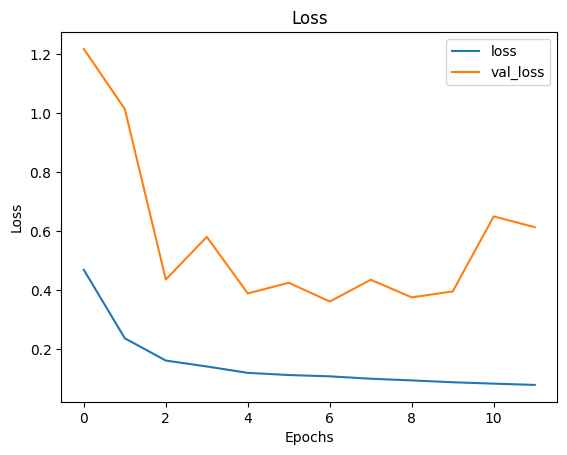

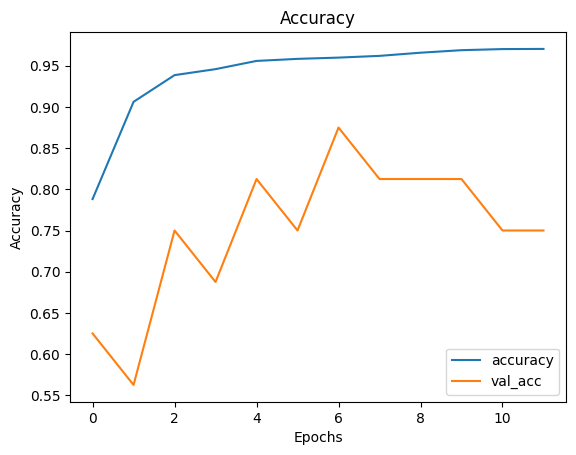

20/20 [==============================] - 0s 9ms/step


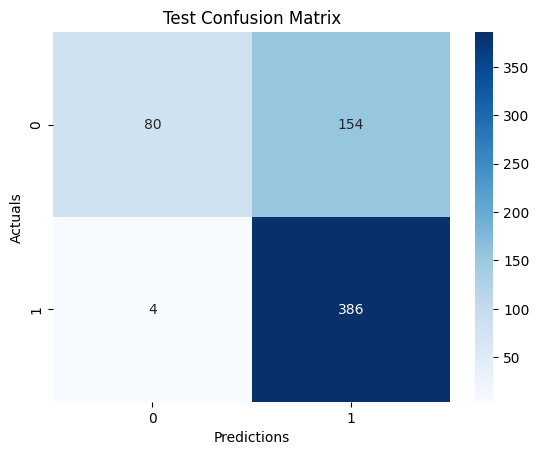

20/20 [==============================] - 0s 10ms/step - loss: 1.0170 - acc: 0.7468
------------------------------
Train Loss: 0.0709426999092102
Train Acc: 0.9739263653755188
------------------------------
Test Loss: 1.0170378684997559
Test Acc: 0.7467948794364929


In [22]:
visualize_CNN_results(history_3)

## CNN With Early Stopping: 4th Model
As we can see from our plot of val accuracy, we might benefit from initiating an early stop using keras callbacks to prevent our model from overfitting.  We'll initiate that in our next iteration below.

In [20]:
early_stopping = EarlyStopping(monitor='val_acc', patience=2)

In [21]:
model_4 = models.Sequential()
model_4.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))



model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])



In [22]:
history_4 = model_4.fit(X_train,
                       y_train,
                       epochs=20,
                       batch_size=20,
                       validation_data=(X_val, y_val),
                       callbacks= [early_stopping])

Epoch 1/20
261/261 [==============================] - 5s 13ms/step - loss: 0.2739 - acc: 0.8825 - val_loss: 0.5423 - val_acc: 0.7500
Epoch 2/20
261/261 [==============================] - 3s 12ms/step - loss: 0.1015 - acc: 0.9630 - val_loss: 0.4857 - val_acc: 0.6875
Epoch 3/20
261/261 [==============================] - 3s 12ms/step - loss: 0.0767 - acc: 0.9718 - val_loss: 0.3896 - val_acc: 0.7500


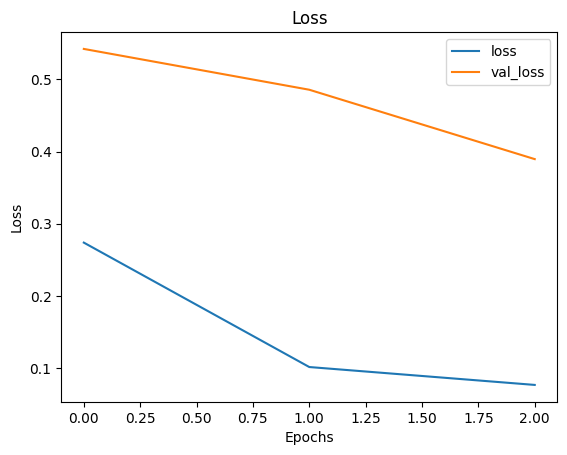

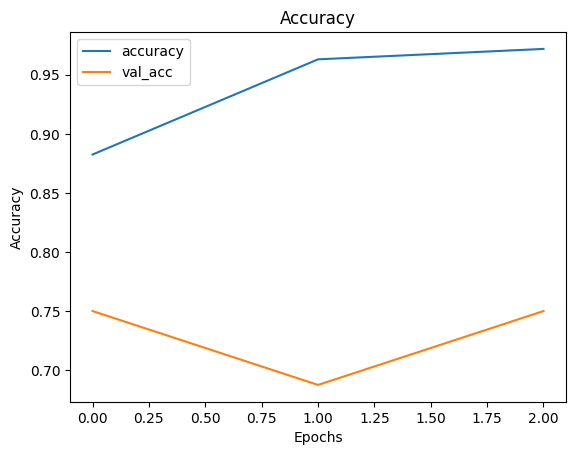

20/20 [==============================] - 0s 10ms/step


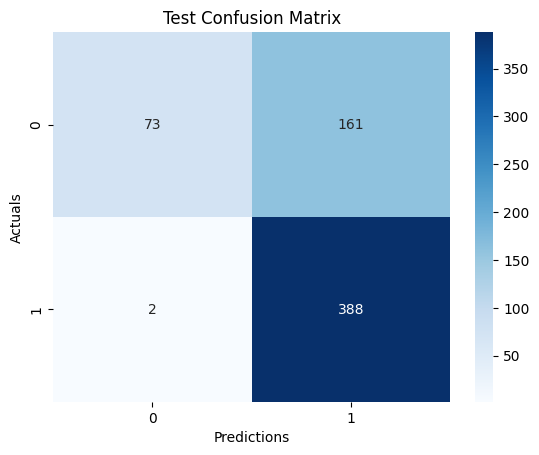

InternalError: ignored

In [23]:
visualize_CNN_results(history_4)

## CNN with Class Weights: 5th Model
while our performance hass certainly improved with a CNN, it's worthwhile to try to address the class imbalance that may be skewing our precision scores.  We'll do that below as we run our third and final model.

In [11]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes= np.unique(y_train),
                                            y= y_train)
weights= dict(zip(np.unique(y_train), weights))
weights

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [12]:
early_stopping = EarlyStopping(monitor='val_acc', patience=3)

In [13]:
model_5 = models.Sequential()
model_5.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_5.add(MaxPooling2D((2, 2)))

model_5.add(Conv2D(32, (3, 3), activation='relu'))
model_5.add(MaxPooling2D((2, 2)))



model_5.add(Conv2D(64, (3, 3), activation='relu'))
model_5.add(MaxPooling2D((2, 2)))

model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [14]:
history_5 = model_5.fit(X_train,
                       y_train,
                       epochs=20,
                       batch_size=20,
                       validation_data=(X_val, y_val),
                       callbacks= [early_stopping],
                       class_weight=weights)

Epoch 1/20
261/261 [==============================] - 16s 13ms/step - loss: 0.3065 - acc: 0.8629 - val_loss: 0.2536 - val_acc: 0.8125
Epoch 2/20
261/261 [==============================] - 3s 12ms/step - loss: 0.1240 - acc: 0.9565 - val_loss: 0.2183 - val_acc: 0.9375
Epoch 3/20
261/261 [==============================] - 3s 12ms/step - loss: 0.0834 - acc: 0.9701 - val_loss: 0.0845 - val_acc: 0.9375
Epoch 4/20
261/261 [==============================] - 3s 12ms/step - loss: 0.0710 - acc: 0.9714 - val_loss: 0.1365 - val_acc: 0.9375
Epoch 5/20
261/261 [==============================] - 3s 12ms/step - loss: 0.0536 - acc: 0.9787 - val_loss: 0.0466 - val_acc: 1.0000
Epoch 6/20
261/261 [==============================] - 3s 12ms/step - loss: 0.0343 - acc: 0.9866 - val_loss: 0.2976 - val_acc: 0.9375
Epoch 7/20
261/261 [==============================] - 3s 12ms/step - loss: 0.0198 - acc: 0.9927 - val_loss: 0.0774 - val_acc: 1.0000
Epoch 8/20
261/261 [==============================] - 3s 11ms/step -

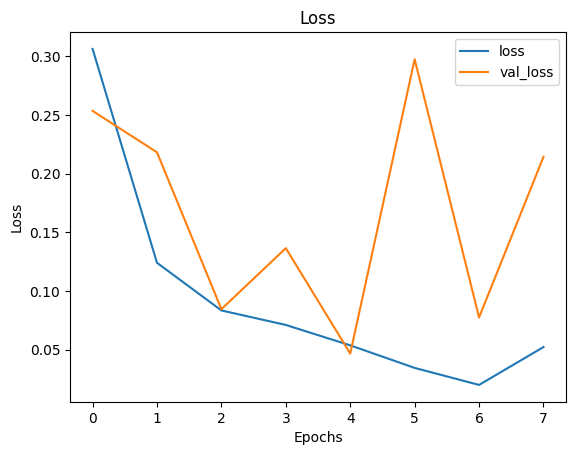

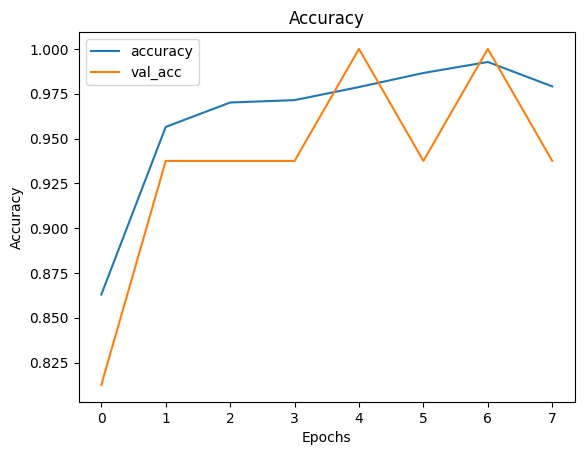

20/20 [==============================] - 0s 9ms/step


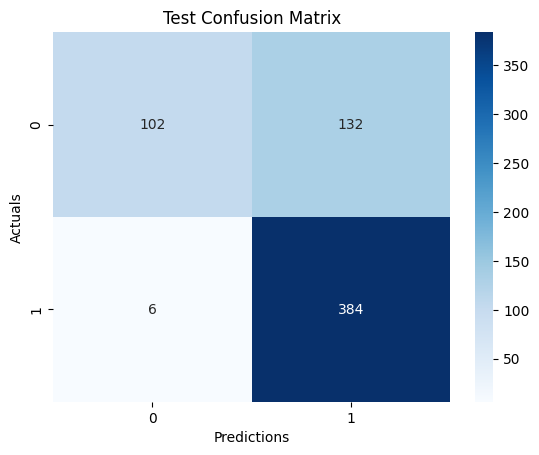

20/20 [==============================] - 0s 10ms/step - loss: 1.1348 - acc: 0.7788
------------------------------
Train Loss: 0.04051437973976135
Train Acc: 0.9865797758102417
------------------------------
Test Loss: 1.1348085403442383
Test Acc: 0.7788461446762085


In [17]:
visualize_CNN_results(history_5)

## Model Evaluation

So which model is best?  Our intent was to maximize our identification of true positives (precision) and minimize false negatives (recall); In other words to be sure we are correctly identifying as many actual cases of pnuemonia, and missing as few instances of illness as possible.  Evaluating our confusion matrixes tells us that all of our models are really not working well, as they are still largely unable to identify pneumonia cases.  Let's move on to a different strategy, using image augmentation and transfer learning.  We'll pick up with that in the Model Augmentation collab notebook.


